# Обучение определения фейковых фактов о COVID и вакцинации

In [40]:
import math

import torch
import pandas as pd
import numpy as np

In [41]:
DEVICE = 'cpu'
if torch.backends.mps.is_available():
    DEVICE = 'mps'
if torch.cuda.is_available():
    DEVICE = 'cuda'

In [42]:
from pathlib import Path

DATA_PATH = Path('data/')
DATA_PATH.mkdir(parents=True, exist_ok=True)

DATA_CACHE = Path('data/cache_dir/')
DATA_CACHE.mkdir(parents=True, exist_ok=True)

DATA_PATH_SAVE_MODELS = Path('data/models/')
DATA_PATH_SAVE_MODELS.mkdir(parents=True, exist_ok=True)

pd.set_option('display.max_colwidth', 500) 

In [43]:
MODEL_NAME = "roberta-base"
TRAIN_DF_NAME = "covid_vaccine_fake_clear.xlsx"
MAX_LENGTH = 128
BATCH_SIZE = 128

# Датасет

In [44]:
data_df = pd.read_excel(DATA_PATH / TRAIN_DF_NAME)
data_df.head(1)

,text,label_idx,original_label_1,source,original_label_2,label_str
0,The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.,0,real,nanyy1025,NaN,Real


In [45]:
data_df = data_df.fillna("")

for col in data_df.select_dtypes(include=["object", "bool"]).columns:
    data_df[col] = data_df[col].astype(str)

In [46]:
label2idx = {key: int(idx) for idx, key in enumerate(data_df['label_str'].unique())}

idx2label = dict([(v, k) for k, v in label2idx.items()])

data_df['label_idx'] = data_df['label_str'].apply(lambda x: label2idx[x])

In [47]:
idx2label

{0: 'Real', 1: 'Fake', 2: 'Comments'}

In [48]:
NUM_CLASSES = len(idx2label)
NUM_CLASSES

3

In [49]:
from sklearn.model_selection import train_test_split

train_val_df, test_df = train_test_split(data_df, test_size=0.1, stratify=data_df["label_idx"], random_state=42, shuffle=True)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, stratify=train_val_df["label_idx"], random_state=42, shuffle=True)

print(f"Размер тренировочного набора: {len(train_df)}")
print(f"Размер валидационного набора: {len(val_df)}")
print(f"Размер тестового набора: {len(test_df)}")

Размер тренировочного набора: 257847
Размер валидационного набора: 28650
Размер тестового набора: 31834


In [50]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import PreTrainedTokenizer
import pandas as pd
from typing import Dict, Tuple


class TokenizedDataset(Dataset):
    def __init__(
        self, 
        dataframe: pd.DataFrame, 
        tokenizer: PreTrainedTokenizer, 
        max_length: int, 
        tensor_dtype: Tuple[torch.dtype, torch.dtype, torch.dtype] = (torch.long, torch.long, torch.long)
    ):
        """
        Инициализация датасета с токенизацией.

        Args:
            dataframe (pd.DataFrame): DataFrame с колонками "text" и "label".
            tokenizer (PreTrainedTokenizer): Токенайзер для преобразования текста.
            max_length (int): Максимальная длина токенов.
            tensor_dtype (tuple): Типы данных для токенов и меток.
        """
        self.tensor_dtype = tensor_dtype

        # Токенизация данных
        tokenized_data = tokenizer(
            dataframe["text"].tolist(),
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        self.input_ids = tokenized_data["input_ids"].to(dtype=self.tensor_dtype[0])
        self.attention_mask = tokenized_data["attention_mask"].to(dtype=self.tensor_dtype[1])
        self.labels = torch.tensor(dataframe["label_idx"].tolist(), dtype=self.tensor_dtype[2])

    def __len__(self) -> int:
        """
        Возвращает количество примеров в датасете.
        """
        return len(self.labels)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        """
        Возвращает токенизированные данные и метки.

        Args:
            idx (int): Индекс примера.

        Returns:
            Dict[str, torch.Tensor]: Словарь с токенами и меткой.
        """
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx],
        }


In [51]:
from torch.utils.data import DataLoader
from transformers import PreTrainedTokenizer
import pandas as pd


def create_dataloader(
    dataframe: pd.DataFrame,
    tokenizer: PreTrainedTokenizer,
    max_length: int = 64,
    batch_size: int = 16,
    shuffle: bool = True,
    tensor_dtype=(torch.long, torch.long, torch.long),
) -> DataLoader:
    """
    Создание DataLoader из DataFrame.

    Args:
        dataframe (pd.DataFrame): DataFrame с колонками "text" и "label".
        tokenizer (PreTrainedTokenizer): Токенайзер для преобразования текста.
        max_length (int): Максимальная длина токенов.
        batch_size (int): Размер батча.
        shuffle (bool): Перемешивать ли данные.
        tensor_dtype (tuple): Типы данных для токенов и меток.

    Returns:
        DataLoader: DataLoader для работы с моделью.
    """
    dataset = TokenizedDataset(dataframe, tokenizer, max_length, tensor_dtype=tensor_dtype)
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
    )
    return dataloader


In [52]:
from transformers import RobertaTokenizer

tokenizer: RobertaTokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME, cache_dir=DATA_CACHE)

train_loader = create_dataloader(
    dataframe=train_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = create_dataloader(
    dataframe=val_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = create_dataloader(
    dataframe=test_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Выводим размер набора данных
print(f"Размер тренировочного набора: {len(train_loader.dataset)}")
print(f"Размер валидационного набора: {len(val_loader.dataset)}")
print(f"Размер тестового набора: {len(test_loader.dataset)}")


Размер тренировочного набора: 257847
Размер валидационного набора: 28650
Размер тестового набора: 31834


# Модель

In [53]:
from typing import Tuple, Dict, Any

import torch
from torch.utils.data import DataLoader
from torch.optim import Optimizer
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score


class VaccineFakeClassifierTrainer:
    def __init__(
        self,
        model: torch.nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        optimizer: Optimizer,
        criterion: torch.nn.Module,
        device: torch.device,
    ):
        """
        Инициализация класса Trainer.

        Args:
            model: Модель для обучения (e.g., RobertaForSequenceClassification).
            train_loader: DataLoader для обучающего набора.
            val_loader: DataLoader для валидационного набора.
            optimizer: Оптимизатор.
            criterion: Функция потерь.
            device: Устройство ('cuda' или 'cpu').
        """
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.history = {
            "train_loss": [],
            "val_loss": [],
            "train_metrics": [],
            "val_metrics": []
        }

        self.model.to(self.device)

    def train_epoch(self) -> Tuple[float, Dict[str, float]]:
        """
        Обучение модели за одну эпоху.

        Returns:
            Средние потери и метрики за эпоху.
        """
        self.model.train()
        running_loss = 0.0
        all_labels = []
        all_preds = []

        for batch in tqdm(self.train_loader, desc="Training"):
            input_ids = batch["input_ids"].to(self.device)
            attention_mask = batch["attention_mask"].to(self.device)
            labels = batch["labels"].to(self.device)

            self.optimizer.zero_grad()

            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            running_loss += loss.item()

            loss.backward()
            self.optimizer.step()

            preds = logits.argmax(dim=-1)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

        all_labels = torch.cat(all_labels)
        all_preds = torch.cat(all_preds)
        metrics = self._compute_metrics(all_preds, all_labels)

        epoch_loss = running_loss / len(self.train_loader)
        return epoch_loss, metrics

    def validate_epoch(self) -> Tuple[float, Dict[str, float]]:
        """
        Валидация модели за одну эпоху.

        Returns:
            Средние потери и метрики за эпоху.
        """
        self.model.eval()
        running_loss = 0.0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Validation"):
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                running_loss += loss.item()

                preds = logits.argmax(dim=-1)
                all_labels.append(labels.cpu())
                all_preds.append(preds.cpu())

        all_labels = torch.cat(all_labels)
        all_preds = torch.cat(all_preds)
        metrics = self._compute_metrics(all_preds, all_labels)

        epoch_loss = running_loss / len(self.val_loader)
        return epoch_loss, metrics

    def fit(self, num_epochs: int):
        """
        Обучение и валидация модели.

        Args:
            num_epochs: Общее количество эпох.
        """
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}")

            train_loss, train_metrics = self.train_epoch()
            val_loss, val_metrics = self.validate_epoch()

            self.history["train_loss"].append(train_loss)
            self.history["val_loss"].append(val_loss)
            self.history["train_metrics"].append(train_metrics)
            self.history["val_metrics"].append(val_metrics)

            print(f"Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")
            print(f"Train Metrics: {train_metrics} | Validation Metrics: {val_metrics}")

    def plot_results(self, metrics_to_plot=None):
        """
        Построение графиков потерь и метрик для обучения и валидации.

        Args:
            metrics_to_plot: Список метрик для визуализации.
        """
        if metrics_to_plot is None:
            metrics_to_plot = ["accuracy", "f1"]

        num_plots = len(metrics_to_plot) + 1
        plt.figure(figsize=(15, 5 * (num_plots // 2 + 1)))

        # График потерь
        plt.subplot((num_plots + 1) // 2, 2, 1)
        plt.plot(self.history["train_loss"], label="Train Loss", color="blue", linestyle="--")
        plt.plot(self.history["val_loss"], label="Validation Loss", color="red", linestyle="-")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss over Epochs")
        plt.legend()
        plt.grid(True)

        # Графики метрик
        for i, metric in enumerate(metrics_to_plot, start=2):
            train_metric = [m[metric] for m in self.history["train_metrics"]]
            val_metric = [m[metric] for m in self.history["val_metrics"]]

            plt.subplot((num_plots + 1) // 2, 2, i)
            plt.plot(train_metric, label=f"Train {metric.capitalize()}", color="blue", linestyle="--")
            plt.plot(val_metric, label=f"Validation {metric.capitalize()}", color="red", linestyle="-")
            plt.xlabel("Epochs")
            plt.ylabel(metric.capitalize())
            plt.title(f"{metric.capitalize()} over Epochs")
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def _compute_metrics(preds: torch.Tensor, labels: torch.Tensor) -> Dict[str, float]:
        """
        Вычисление метрик.

        Args:
            preds: Предсказания модели.
            labels: Истинные метки.

        Returns:
            Словарь метрик.
        """
        preds = preds.numpy()
        labels = labels.numpy()

        metrics = {
            "accuracy": accuracy_score(labels, preds),
            "f1": f1_score(labels, preds, average="weighted"),
        }
        return metrics


# Обучение

In [63]:
import torch
from torch.optim import AdamW
from transformers import RobertaForSequenceClassification

LEARNING_RATE = 1e-5
NUM_EPOCHS = 5
WEIGHT_DECAY = 0.01

model = RobertaForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_CLASSES, cache_dir=DATA_CACHE)

model.to(DEVICE)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.CrossEntropyLoss()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
from torch.optim import Adagrad, RMSprop

optimizer = Adagrad(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

optimizer = RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, alpha=0.9, momentum=0.9)

In [65]:
trainer = VaccineFakeClassifierTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=DEVICE,
)

In [66]:
trainer.fit(num_epochs=NUM_EPOCHS)


Epoch 1/5


Training:   0%|          | 0/2015 [00:00<?, ?it/s]

Validation:   0%|          | 0/224 [00:00<?, ?it/s]

Train Loss: 0.0541 | Validation Loss: 0.0443
Train Metrics: {'accuracy': 0.9822336501879021, 'f1': 0.9815337053993495} | Validation Metrics: {'accuracy': 0.9833158813263525, 'f1': 0.9831396683224269}

Epoch 2/5


Training:   0%|          | 0/2015 [00:00<?, ?it/s]

Validation:   0%|          | 0/224 [00:00<?, ?it/s]

Train Loss: 0.0562 | Validation Loss: 0.0606
Train Metrics: {'accuracy': 0.982128936927713, 'f1': 0.9812870330371326} | Validation Metrics: {'accuracy': 0.9793019197207679, 'f1': 0.9804811448334781}

Epoch 3/5


Training:   0%|          | 0/2015 [00:00<?, ?it/s]

Validation:   0%|          | 0/224 [00:00<?, ?it/s]

Train Loss: 0.0518 | Validation Loss: 0.0399
Train Metrics: {'accuracy': 0.9833583481677118, 'f1': 0.9826824943530623} | Validation Metrics: {'accuracy': 0.9883420593368237, 'f1': 0.9877570610525359}

Epoch 4/5


Training:   0%|          | 0/2015 [00:00<?, ?it/s]

Validation:   0%|          | 0/224 [00:00<?, ?it/s]

Train Loss: 0.0488 | Validation Loss: 0.0370
Train Metrics: {'accuracy': 0.9840913409890362, 'f1': 0.9834975187452157} | Validation Metrics: {'accuracy': 0.9881675392670157, 'f1': 0.9877991591475995}

Epoch 5/5


Training:   0%|          | 0/2015 [00:00<?, ?it/s]

Validation:   0%|          | 0/224 [00:00<?, ?it/s]

Train Loss: 0.0486 | Validation Loss: 0.0374
Train Metrics: {'accuracy': 0.9850570299441141, 'f1': 0.9845313369932245} | Validation Metrics: {'accuracy': 0.9863874345549738, 'f1': 0.9864605894817933}


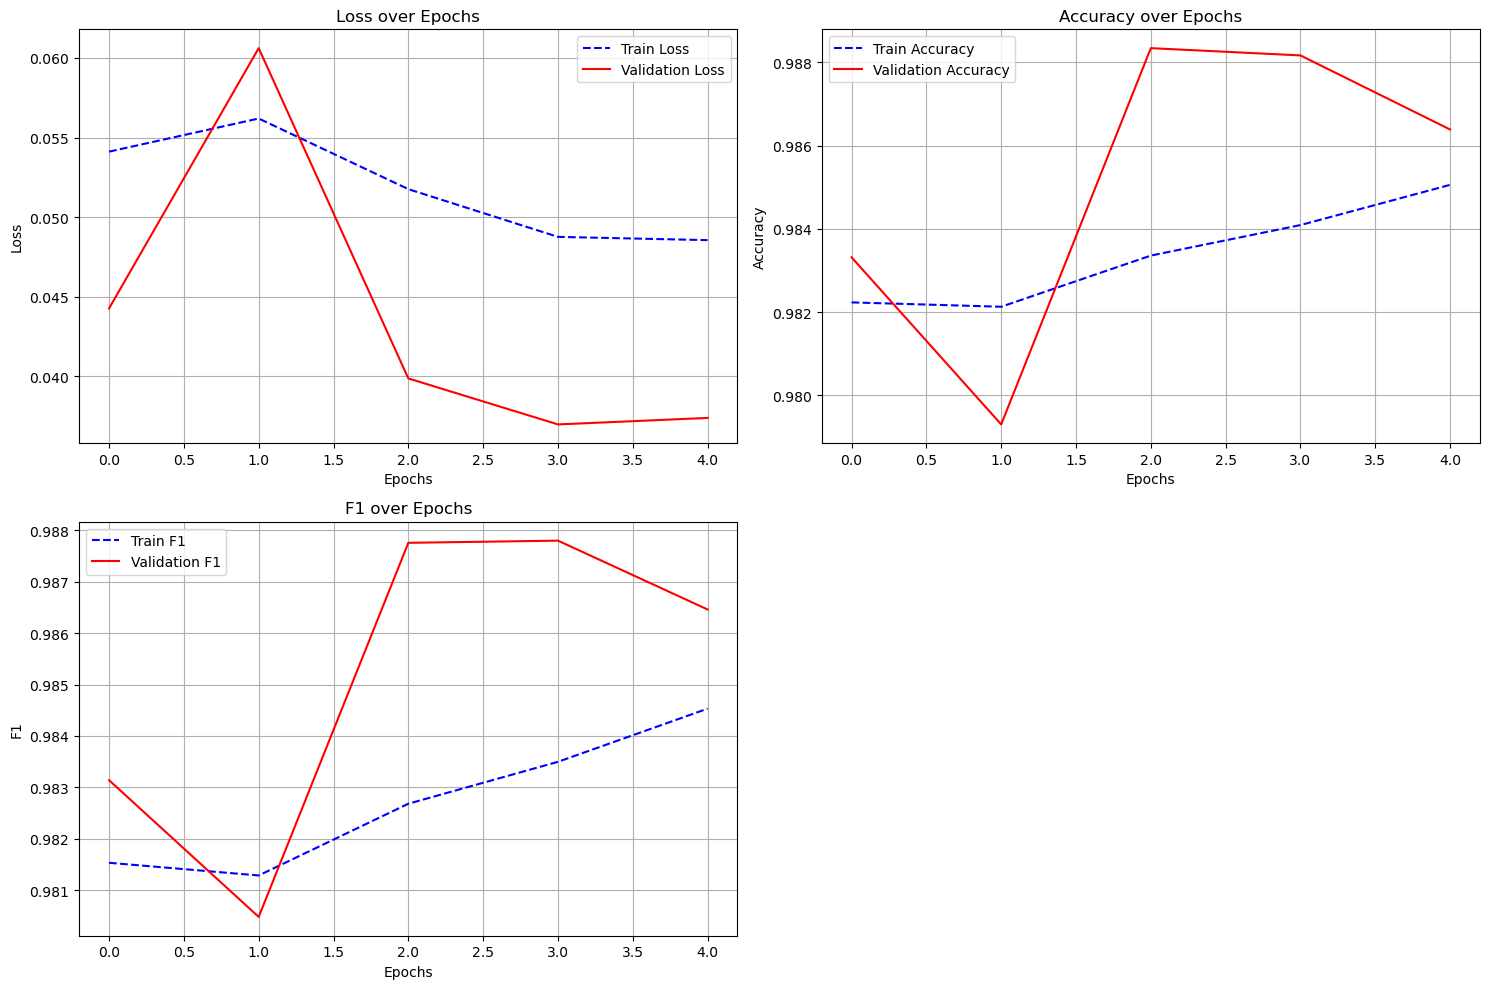

In [67]:
trainer.plot_results()

In [68]:
model_save_path = DATA_PATH_SAVE_MODELS / "covid_vaccine_fake_model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Модель и токинайзер сохранены в: {model_save_path}")

Модель и токинайзер сохранены в: data\models\covid_vaccine_fake_model


# Тестирование

In [69]:
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score


def test_model(
    model: torch.nn.Module,
    test_loader: DataLoader,
    test_df: pd.DataFrame,
    idx2label: dict,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
) -> pd.DataFrame:
    """
    Тестирует модель на тестовом DataLoader и возвращает DataFrame с результатами.

    Args:
        model (torch.nn.Module): Обученная модель.
        test_loader (DataLoader): DataLoader для тестового набора.
        test_df (pd.DataFrame): Исходный DataFrame тестовых данных.
        idx2label (dict): Словарь, отображающий индексы категорий в названия.
        device (torch.device): Устройство для вычислений (CPU/GPU).

    Returns:
        pd.DataFrame: DataFrame с результатами, содержащий:
            - 'text': текст примера,
            - 'true_label': истинная метка,
            - 'predicted_label': предсказанная метка,
            - 'probability': вероятность предсказания,
            - 'correct': корректность предсказания (True/False).
    """
    model.eval()
    model.to(device)

    test_results = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            true_labels = batch["labels"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probabilities = torch.softmax(logits, dim=-1).cpu().numpy()

            predictions = torch.argmax(logits, dim=-1).cpu().numpy()
            true_labels = true_labels.cpu().numpy()

            for true_label, predicted_label, probs in zip(true_labels, predictions, probabilities):
                test_results.append({
                    "true_label": idx2label[true_label],
                    "predicted_label": idx2label[predicted_label],
                    "probability": probs.tolist(),
                    "correct": true_label == predicted_label,
                })

    test_results_df = pd.DataFrame(test_results)

    test_df = test_df.reset_index(drop=True)
    test_df = pd.concat([test_df, test_results_df], axis=1)

    accuracy = accuracy_score(test_df["true_label"], test_df["predicted_label"])
    f1 = f1_score(test_df["true_label"], test_df["predicted_label"], average="weighted")

    print("\n=== Результаты тестирования ===")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"F1 Score: {f1:.4f}")

    return test_df


In [70]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained(DATA_PATH_SAVE_MODELS / "covid_vaccine_fake_model")
model = RobertaForSequenceClassification.from_pretrained(
    DATA_PATH_SAVE_MODELS / "covid_vaccine_fake_model")

model.to(DEVICE)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [71]:
test_results_df = test_model(
    model=model,
    test_loader=test_loader,
    test_df=test_df,
    idx2label=idx2label,
    device=DEVICE,
)

Testing:   0%|          | 0/249 [00:00<?, ?it/s]


=== Результаты тестирования ===
Accuracy: 98.72%
F1 Score: 0.9872


In [78]:
test_results_df.sample(10)

,text,label_idx,original_label_1,source,original_label_2,label_str,true_label,predicted_label,probability,correct
31079,and are here but for some reason are reinacting the invisble man and cant be seen,2,False,twitter,,Comments,Comments,Comments,"[0.0008607598138041794, 0.001457554753869772, 0.997681736946106]",True
12560,and my bird is a crazy one lol i let her free 2 times a day and she enjoys it a lot! and flies back in her cage alone,2,True,twitter,,Comments,Comments,Comments,"[9.040887380251661e-05, 0.00040863838512450457, 0.9995008707046509]",True
31246,utc discussed continuum involve aerobic muscle fibers even primarily anaerobic activities simply contribute much overall effort see chart aerobic component well less activities well past low rep high weight range even aerobic component would still qualify primarily anaerobic reliable sources idea low rep high weight trainging provides important aerobic training component epoc count simply body recovering anaerobic work uses oxygen aerobic sense mar,2,True,toxic_comments,,Comments,Comments,Comments,"[0.002919347956776619, 0.005923592951148748, 0.991157054901123]",True
10248,suck making article tag deletion power hungry nerd,2,False,toxic_comments,,Comments,Comments,Comments,"[7.635225483682007e-05, 0.0004394539864733815, 0.9994841814041138]",True
25473,"Ok, time for softball. First game of the season comes with BBQ e ya later!!!",2,True,twitter,,Comments,Comments,Comments,"[0.00035455849138088524, 0.0008138177217915654, 0.998831570148468]",True
14465,&quot;Your application for press passes to Spinal Tap at Wembley Arena was declined on this occasion&quot; - This? it's THE only occasion. bahhh!,2,False,twitter,,Comments,Comments,Comments,"[0.00012583163334056735, 0.0005108725745230913, 0.999363362789154]",True
11095,I am lost. Please help me find a good home.,2,False,twitter,,Comments,Comments,Comments,"[8.103457366814837e-05, 0.0002922313869930804, 0.9996267557144165]",True
24903,recommended deletion since lack noteworthiness since one carries much less watches piece shit channel pretend like never existed pussy liberal land deleting faggot page thanks fuck micropenises pussies,2,False,toxic_comments,,Comments,Comments,Comments,"[0.00015943053585942835, 0.0007165165152400732, 0.9991239905357361]",True
7307,sounds good,2,True,twitter,,Comments,Comments,Comments,"[7.585380808450282e-05, 0.00046251885942183435, 0.9994615912437439]",True
27078,A video has been viewed hundreds of thousands of times in multiple Facebook posts which claim it shows two Italian doctors who contracted novel coronavirus which causes the disease COVID-19 while treating patients.,1,fake,nanyy1025,,Fake,Fake,Fake,"[0.1880740225315094, 0.8084573149681091, 0.0034686557482928038]",True


In [73]:
test_results_df.to_excel(DATA_PATH / 'test_results_learning.xlsx', index=False)

In [74]:
from transformers import PreTrainedTokenizer, PreTrainedModel
import torch


def test_model_with_text(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    text: str,
    max_length: int = 128,
    label_map: dict = None,
):
    """
    Проверяет модель на введенном вручную тексте, используя argmax для классификации.

    Args:
        model (PreTrainedModel): Загруженная обученная модель (например, RobertaForSequenceClassification).
        tokenizer (PreTrainedTokenizer): Токенизатор для подготовки текста.
        text (str): Текст для классификации.
        max_length (int): Максимальная длина токенизированного текста.
        label_map (dict): Словарь для отображения меток, если метки числовые.

    Returns:
        dict: Словарь с текстом, вероятностями и предсказанными метками.
    """

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    inputs = tokenizer(
        text,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]  # Вероятности для каждого класса

    predicted_index = torch.argmax(logits, dim=-1).item()
    predicted_label = label_map[predicted_index] if label_map else predicted_index

    # Результаты
    result = {
        "text": text,
        "probabilities": probs.tolist(),
        "predicted_label": predicted_label
    }

    return result


Real

In [75]:
text = "COVID-19 vaccines do not affect fertility or reproductive health. This has been confirmed through multiple studies and ongoing research."

result = test_model_with_text(
    model=model,
    tokenizer=tokenizer,
    text=text,
    max_length=128,
    label_map=idx2label
)

print(result)

{'text': 'COVID-19 vaccines do not affect fertility or reproductive health. This has been confirmed through multiple studies and ongoing research.', 'probabilities': [0.5359705090522766, 0.4630146622657776, 0.0010147941065952182], 'predicted_label': 'Real'}


Fake

In [76]:
text = "COVID-19 vaccines affect fertility or reproductive health."

result = test_model_with_text(
    model=model,
    tokenizer=tokenizer,
    text=text,
    max_length=128,
    label_map=idx2label
)

print(result)

{'text': 'COVID-19 vaccines affect fertility or reproductive health.', 'probabilities': [0.2827509641647339, 0.7156590223312378, 0.0015899945283308625], 'predicted_label': 'Fake'}


In [77]:
text = "Arginine gave me a powerful boost of energy, I can really feel how it pumped me up. In the gym, it’s way easier to handle the weights, and my endurance is through the roof. It feels like my muscles are growing before my eyes, and the post-workout feeling is just awesome. I’m enjoying every moment as I feel my body reacting to the load. It’s definitely a great motivation to keep pushing forward! covid ruined everything though"

result = test_model_with_text(
    model=model,
    tokenizer=tokenizer,
    text=text,
    max_length=128,
    label_map=idx2label
)

print(result)

text = '''
The new strain of the Omicron coronavirus was first detected in South Africa and Botswana in November 2021. It is rapidly spreading all over the world. The omicron strain contains more than 30 mutations in the S-protein spike on the virus shell, with which it enters the cell.
'''
result = test_model_with_text(
    model=model,
    tokenizer=tokenizer,
    text=text,
    max_length=128,
    label_map=idx2label
)

print(result)

{'text': 'Arginine gave me a powerful boost of energy, I can really feel how it pumped me up. In the gym, it’s way easier to handle the weights, and my endurance is through the roof. It feels like my muscles are growing before my eyes, and the post-workout feeling is just awesome. I’m enjoying every moment as I feel my body reacting to the load. It’s definitely a great motivation to keep pushing forward! covid ruined everything though', 'probabilities': [0.006544374395161867, 0.02012632228434086, 0.9733293652534485], 'predicted_label': 'Comments'}
{'text': '\nThe new strain of the Omicron coronavirus was first detected in South Africa and Botswana in November 2021. It is rapidly spreading all over the world. The omicron strain contains more than 30 mutations in the S-protein spike on the virus shell, with which it enters the cell.\n', 'probabilities': [0.6404542326927185, 0.35772162675857544, 0.0018241491634398699], 'predicted_label': 'Real'}
